#Deep Reinforcement Learning final project Tandem-Chess AI 
Felix Japtok 977397, Jan Kettler 979374

##import packages and define some global methods

In [74]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import copyreg
import os
import random
import time
import matplotlib.pyplot as plt

In [75]:
#method to measure time it takes to train for example
def get_time(start):
  current = time.time()
  time_steps = current - start
  return round(time_steps, 5)

def get_average(list):
  return sum(list) / len(list)

def print_tensor(tensor, dim = 2):
  if (dim > 4):
    print("Dimensions higher than 4 are not supported")
    return
  if (dim > len(tensor.shape)):
    print("Tensor has not enough dimensions")
    return
  if (dim == 1):
    for e in tensor:
      print(e)
  if (dim == 2):
    for e in tensor:
      for p in e:
        print(p)
  if (dim == 3):
    for e in tensor:
      for p in e:
        for q in p:
          print(q)
  if (dim == 4):
    for e in tensor:
        for p in e:
          for q in p:
            for t in q:
              print(t)

##Board

In [76]:
class Chessboard():
  def __init__(self):
    ''' The chessboard class represents a gamestate of the game chess. It stores an 8x8 array which holds the pieces currently in play for each player (black and white).
    This is mainly a container for the array and other variables that we need to keep track of but it also has some basic functionalities. 
    Most importantly it manages getting all legal moves for a boardstate and has a function to transform the stored information to a tensor.
    '''
    self.pieces = []
    self.fiftyMoveRule = 0
    self.gameOver = False
    self.white_to_move = True
    self.kings = []
    self.value_advantage = 0.0001
    self.allowed_moves = []
    self.played_moves = []
    self.whitePieces = []
    self.blackPieces = []
    self.allPieces = [self.blackPieces, self.whitePieces]
    self.prepare_board(True)
    self.visited_boardstates = {}
    self.black_insertable_pieces = {Pawn: 0, Knight:0, Bishop:0, Rook:0,Queen:0}
    self.white_insertable_pieces = {Pawn: 0, Knight:0, Bishop:0, Rook:0, Queen:0}
    self.insertable_pieces = [self.black_insertable_pieces, self.white_insertable_pieces]
    self.black_taken_pieces = {Pawn: 0, Knight:0, Bishop:0, Rook:0,Queen:0}
    self.white_taken_pieces = {Pawn: 0, Knight:0, Bishop:0, Rook:0, Queen:0}
    self.taken_pieces = [self.black_taken_pieces, self.white_taken_pieces]

                          #56 Queen moves
    self.move_val_dict= {0: (0,1), 1: (0,2), 2: (0,3), 3: (0,4), 4: (0,5), 5: (0,6), 6: (0,7), 7: (1,1), 8: (2,2), 9: (3,3),
                         10: (4,4), 11: (5,5), 12: (6,6), 13: (7,7), 14: (1,0), 15: (2,0), 16: (3,0), 17: (4,0), 18: (5,0),
                         19: (6,0), 20: (7,0), 21: (1,-1), 22: (2,-2), 23: (3,-3), 24: (4,-4), 25: (5,-5), 26: (6,-6), 27: (7,-7),
                         28: (0,-1), 29: (0,-2), 30: (0,-3), 31: (0,-4), 32: (0,-5), 33: (0,-6), 34: (0,-7), 35: (-1,-1), 36: (-2,-2), 
                         37: (-3,-3), 38: (-4,-4), 39: (-5,-5), 40: (-6,-6), 41: (-7,-7), 42: (-1,0), 43: (-2,0), 44: (-3,0), 45: (-4,0), 
                         46: (-5,0), 47: (-6,0), 48: (-7,0), 49: (-1,1), 50: (-2,2), 51: (-3,3), 52: (-4,4), 53: (-5,5), 54: (-6,6), 55: (-7,7), 
                         # Knight moves starting at 56 
                         56: (1,2), 57: (2,1), 58: (2,-1), 59: (1,-2), 60: (-1,-2), 61: (-2,-1), 62: (-2,1), 63: (-1,2),
                         # Pawn underpromotions 64-66 = forward-move,  67-69 = forward+left(-x_ind), 70-72 forward+right(+x_idx)
                         64: (Knight), 65: (Bishop), 66: (Rook), 67: (Knight), 68: (Bishop), 69: (Rook), 70: (Knight), 71: (Bishop), 72: (Rook),
                         #Piece insertion value is the corresponding idx in the insertable_pieces list
                         73: Pawn, 74: Knight, 75: Bishop, 76: Rook, 77: Queen,
                         #Castling
                         78: ("rightCastle"), 79: ("leftCastle")
    }

  def __str__(self):
    prettyprint = { "None" : "  ", "wRook": "wR", "bRook": "bR", "wKnight" : "wk", "bKnight" : "bk", "wBishop" : "wB",
                        "bBishop" : "bB", "wQueen" : "wQ", "bQueen" : "bQ", "wKing" : "wK!", "bKing" : "bK!", "bPawn" : "bP", "wPawn" : "wP"}
    arr = []
    for e in self.board:
      arr.append([prettyprint[str(i)] for i in e])    
    return str(np.array(arr))

  def reset(self):
    #reset current state to start state
    self.pieces = []
    self.fiftyMoveRule = 0
    self.gameOver = False
    self.white_to_move = True
    self.value_advantage = 0.0001
    self.played_moves = []
    self.prepare_board()
    self.visited_boardstates = {}
    
  def prepare_board(self, not_testing = True):
    #setup the array with pieces correctly for a new game
    self.board = np.empty([8,8],dtype = object)
    self.wKing = King( (0,4), True)
    self.bKing = King( (7,4), False)
    self.kings = [self.bKing,self.wKing]
    self.board[0] = [Rook((0,0), True ),Knight((0,1), True),Bishop((0,2), True),Queen((0,3), True),self.wKing ,Bishop((0,5), True),Knight((0,6), True),Rook((0,7), True)]
    self.board[7] = [Rook((7,0), False),Knight((7,1), False),Bishop((7,2), False),Queen((7,3), False),self.bKing ,Bishop((7,5), False),Knight((7,6), False),Rook((7,7), False)]
    self.board[1] = [Pawn((1,0), True),Pawn((1,1), True),Pawn((1,2), True),Pawn((1,3), True),Pawn((1,4), True),Pawn((1,5), True),Pawn((1,6), True),Pawn((1,7), True)]
    self.board[6] = [Pawn((6,0), False),Pawn((6,1), False),Pawn((6,2), False),Pawn((6,3), False),Pawn((6,4), False),Pawn((6,5), False),Pawn((6,6), False),Pawn((6,7), False)]
    if not_testing:
      for row in self.board:
        for piece in row:
          try:
            if piece.getColor() == True:
              self.whitePieces.append(piece)
            else:
              self.blackPieces.append(piece)
          except:pass
    self.allowed_moves = []

  def prepare_testboard(self, not_testing = True):
    #special boardstate we used for testing
    self.board = np.empty([8,8],dtype = object)
    self.wKing = King( (1,5), True)
    self.bKing = King( (7,4), False)
    self.kings = [self.bKing,self.wKing]
    self.board[0] = [Rook((0,0), True ),Knight((0,1), True),Bishop((0,2), True),Queen((0,3), True),None ,Bishop((0,5), True),Knight((0,6), True),Rook((0,7), True)]
    self.board[7] = [Rook((7,0), False),Knight((7,1), False),Bishop((7,2), False),Queen((7,3), False),self.bKing ,Bishop((7,5), False),Knight((7,6), False),Rook((7,7), False)]
    self.board[1] = [Pawn((1,0), True),Pawn((1,1), True),Pawn((1,2), True),Pawn((1,3), True),Pawn((1,4), True),Pawn((1,5), True),Pawn((1,6), True),Pawn((1,7), True)]
    self.board[6] = [Pawn((6,0), False),Pawn((6,1), False),Pawn((6,2), False),Pawn((6,3), False),Pawn((6,4), False),Pawn((6,5), False),Pawn((6,6), False),Pawn((6,7), False)]
    self.board[2][6] = Pawn((2,6), False)
    self.board[1][5] = self.wKing
    self.board[2][3] = Queen((2,3), True)
    self.board[6][4] = Queen((6,4), False)
    self.board[2][2] = Bishop((2,2),False)
    self.board[1][3] = Knight((1,3), True)
    self.board[0][5] = None
    self.board[0][6] = None
    self.board[6][6] = None
    self.board[7][6] = None
    if not_testing:
      for row in self.board:
        for piece in row:
          try:
            if piece.getColor() == True:
              self.whitePieces.append(piece)
            else:
              self.blackPieces.append(piece)
          except:pass

  def prepare_checkmateinone(self, not_testing = True):
    #special boardstate we used for testing
    self.board = np.empty([8,8],dtype = object)
    self.wKing = King( (0,2), True)
    self.bKing = King( (3,7), False)
    self.kings = [self.bKing,self.wKing]
    self.board[0] = [None, Rook((0,1), False),self.wKing,Rook((0,3), True),Queen((0,4),False) ,Bishop((0,5), True),Knight((0,6), True),Rook((0,7), True)]
    self.board[1] = [Bishop((1,0),False), Pawn((1,1),True),None,None,Pawn((1,4),True),None,Pawn((1,6),True),None]
    self.board[3][7] = self.bKing
    self.whitePieces= []
    self.blackPieces= []
    self.allPieces = []
    if not_testing:
      for row in self.board:
        for piece in row:
          try:
            if piece.getColor() == True:
              self.whitePieces.append(piece)
            else:
              self.blackPieces.append(piece)
          except:pass
    self.allPieces= [self.blackPieces,self.whitePieces]
    self.allowed_moves = []
    print(self)

  def getPiece(self, position):
    return self.board[position[0],position[1]]

  def isInside(self,y,x):
    # index inside of array lenght
    if (y in range(0,8) and x in range(0,8)):
      return True
    return False

  def pawnUnderPromotion(self, y, x, move_val):
    #Pawn underpromotions 64-66 = forward-move,  67-69 = forward+left(-x_ind), 70-72 forward+right(+x_idx)
    pawn = self.getPiece((y,x))
    color = pawn.getColor()
    if move_val <67:
      new_pos = (y+pawn.direction,x)
    elif move_val > 69:
      new_pos = (y+pawn.direction, x+1)
    elif 66 < move_val < 70:
      new_pos = (y+pawn.direction, x-1)
    #instantiate new piece
    new_piece = self.move_val_dict[move_val]((y,x),color)
    new_piece.used_to_be_pawn = True
    self.allPieces[color].remove(pawn)
    self.allPieces[color].append(new_piece)
    self.swapPositions(new_piece, new_pos)

  def insertPiece(self, y_pos, x_pos, move_val, actual_move = False):
    #instatiate new piece with color of current player
    new_piece = self.move_val_dict[move_val]((y_pos,x_pos), self.white_to_move)
    self.board[y_pos][x_pos] = new_piece
    int_wtm = int(self.white_to_move)
    # insertion moves start at 73 so we use it to index the list of taken pieces
    self.insertable_pieces[int_wtm][type(new_piece)] -= 1
    new_piece.has_moved = True
    if actual_move:
      self.update_insertable_pieces(new_piece)
    self.allPieces[int_wtm].append(new_piece)
    

  def update_insertable_pieces(self,piece):
    self.boardmanager.update_insertable_pieces(self,piece)

  def swapPositions(self, piece, position):
    taken_piece = self.getPiece(position)
    # Pawns that promoted can only be inserted as pawns again
    if not taken_piece is None:
      try:
        if taken_piece.used_to_be_pawn:
          self.taken_pieces[taken_piece.getColor()][0] +=1
      except:
        self.taken_pieces[taken_piece.getColor()][type(taken_piece)] +=1
      self.allPieces[taken_piece.getColor()].remove(taken_piece)
    org_pos = piece.position
    self.board[position] = piece
    piece.move(position)
    self.board[org_pos] = None

  def castle(self, y, x, move_val):
    king = self.getPiece((y,x))
    # Castle to the right(Kings-side)
    if move_val == 78:
      king_moves_to = (y,x+2)
      rook_moves_to = (y,x+1)
      rook = self.getPiece((y,x+3))
    # castle to the left(Queen-side)
    else:
      king_moves_to = (y,x-2)
      rook_moves_to = (y,x-1)
      rook = self.getPiece((y,x-4))
    self.swapPositions(king, king_moves_to)
    self.swapPositions(rook, rook_moves_to)

  def movePiece(self, move, actual_move = False):
    ''' This method is responsible for moving a piece on the board. Based on the move-value of the move '''
    y,x,move_val = move
    if move_val < 64:
      direction = self.move_val_dict[move_val]
      end_pos = (y + direction[0], x + direction[1])
      piece = self.getPiece((y,x))
      if piece is None:
        print(self)
        pieces = []
        piece_pos = []
        for c in self.allPieces:
          for p in c:
            pieces.append(p)
            piece_pos.append(p.position)
        print(pieces)
        print(piece_pos)
        raise
      # onpassant and Promotion is a special case
      if (isinstance(piece,Pawn)):
        #onpassant- to first take the pawn and then move to endposition
        if (self.getPiece(end_pos) is None and direction[1] != 0):
          self.swapPositions(piece, (y,x + direction[1]))
        #promotion to Queen
        elif (end_pos[0] in [0,7]):
          c = piece.getColor()
          self.allPieces[c].remove(piece)
          piece = Queen((y,x),c)
          piece.used_to_be_pawn = True
          self.board[y][x] = piece
          self.allPieces[c].append(piece)
      self.swapPositions(piece, end_pos)
    elif move_val < 73:
      self.pawnUnderPromotion(y,x,move_val)
    elif move_val < 78:
      self.insertPiece(y,x,move_val, actual_move)
    # only castling moves left
    elif move_val < 80:
      self.castle(y,x,move_val)
    else:
      print(self)
      print(y,x,move_val)
      for l in self.allPieces:
        for piece in l:
          print([piece,piece.position])
      raise
    self.addBoardstateToSeen()
    self.white_to_move = not self.white_to_move

  def get_input(self, message, keep_shape = True):
    '''Transform current boardstate to a tensor for evaluation of the Network. The message for current agent gets attached to the input.'''

    vocab = {"None" : 0, "wPawn" : 1, "wRook" : 2, "wKnight" : 3, "wBishop" : 4, "wQueen" : 5, "wKing" : 6, "bPawn" : 7, "bRook" : 8, "bKnight" : 9, "bBishop" : 10, "bQueen" : 11, "bKing" : 12}
    int_board = []
    if keep_shape:
      #for keeping the structure of the board: shape = 8x8
      for row in self.board:
        int_board.append([vocab[str(piece)] for piece in row]) 
    else:
      #for losing the structure of the board: shape = 64
      for row in board:
        for piece in row:
          int_board.append(vocab[str(piece)])                
    #create one hot encoded board of shape 8x8x13 or 64x13
    oh_board = tf.one_hot(int_board, 13)
    # add if white or black is to move to tensor and pieces available for insertion
    if self.white_to_move:
      available_pieces = self.insertable_pieces[int(self.white_to_move)]
      pieces = [int(self.white_to_move), int(available_pieces[Pawn] > 0), int(available_pieces[Rook] > 0), int(available_pieces[Knight] > 0), int(available_pieces[Bishop] > 0) ,int(available_pieces[Queen] > 0)]
    else:
      available_pieces = self.insertable_pieces[int(self.white_to_move)]
      pieces = [int(self.white_to_move), int(available_pieces[Pawn] > 0), int(available_pieces[Rook] > 0), int(available_pieces[Knight] > 0), int(available_pieces[Bishop] > 0) ,int(available_pieces[Queen] > 0)]
    #create input in desired shape and append the available pieces and who's turn it is for the next move to the one hot encoded pieces
    np_board = oh_board.numpy()
    input = np.zeros(shape = (8,8,19))
    for i,row in enumerate(np_board):
      for j,piece in enumerate(row):
        input[i][j] = np.append(piece, pieces, axis = 0)
    input = tf.convert_to_tensor(input)
    input = tf.concat((input,message), axis = 2)
    return input

  def getID(self, string = True):
    #method to get a ID for current board to check if boardstate was encountered already
    vocab = {"None" : 0, "wPawn" : 1, "wRook" : 2, "wKnight" : 3, "wBishop" : 4, "wQueen" : 5, "wKing" : 6, "bPawn" : 7, "bRook" : 8, "bKnight" : 9, "bBishop" : 10, "bQueen" : 11, "bKing" : 12}
    int_board = []
    if (string):
      s = ""
      for row in self.board:
        for piece in row:
          s += str(vocab[str(piece)])
      white_to_move = int(self.white_to_move)
      s += str(white_to_move)
      return s
    for row in self.board:
      for piece in row:
        int_board.append(vocab[str(piece)])                 #shape: (64,13)
    return  int_board

  def addBoardstateToSeen(self):
    #adds boardstate to seen boardstates and increases its counter
    id = self.getID(True)
    self.addCountToDict(int(id))

  def addCountToDict(self, id):
    if (id in self.visited_boardstates.keys()):
      self.visited_boardstates[id] += 1
    else:
      self.visited_boardstates[id] = 1

  def getInsertionMoves(self, squares_to_block = None):
    '''This method appends all legal Piece insertions to the allowed moves. We can generally only insert Pieces if the corresponding
     piece got taken from our teammate on the other board and the square where the piece would get inserted is empty. Additionally if
     the King is currently in check pieces can only be inserted into squares so that they block the attack on the King. Pawns can not be inserted in the backranks.'''
    available_pieces = self.insertable_pieces[int(self.white_to_move)]
    i = 1
    piece_count_total = list(available_pieces.values())
    if (squares_to_block):
      if not isinstance(squares_to_block, list):
        squares_to_block = [squares_to_block]
      if piece_count_total[0] > 0:
        for row_idx, row in enumerate(self.board[1:7]):
          for col_idx, square in enumerate(row):
            if (square is None and (row_idx +1,col_idx) in squares_to_block): #73 = pawn insertion, 74 = Knight, 75 = Bishop, 76 = Rook, 77 = Queen
              self.allowed_moves.append([row_idx+1, col_idx,73])
      piece_count_total = piece_count_total[1:]
      for piece_count in piece_count_total:
        if piece_count > 0:
          for row_idx, row in enumerate(self.board):
            for col_idx, square in enumerate(row):
              if (square is None and (row_idx,col_idx) in squares_to_block):
                self.allowed_moves.append([row_idx, col_idx,73 + i])
        i = i+1
    else:
      if piece_count_total[0] > 0:
        for row_idx, row in enumerate(self.board[1:7]):
          for col_idx, square in enumerate(row):
            if (square is None):
              self.allowed_moves.append([row_idx+1, col_idx,73])
      piece_count_total = piece_count_total[1:]
      for piece_count in piece_count_total:
        if piece_count > 0:
          for row_idx, row in enumerate(self.board):
            for col_idx, square in enumerate(row):
              if (square is None):
                self.allowed_moves.append([row_idx, col_idx,73 + i])
        i = i+1

  def getMoves(self):
    '''This method returns all legal moves for the current Boardstate. To do that the King of the player that is currently to move first checks if it is under attack and if any pieces are pinned to the king.
    If any pieces are pinned to the king they can only move along the direction of the pin so that they cannot break the pin, leaving the king in check afterwards. Additionally if the King is under attack
    it returns a list squares_to_block, specifying all squares, where a piece can move to, to block the attack. Legal moves are only these moves that dont break a pin and end up at a square where they block
    the attack on the King. If the King is attack from multiple angles at onces, the attack cannot be blocked, hence the only legal moves are King-moves moving it out of danger.
    All moves have the form of [y_coordinate, x_coordinate, move_value] where move_value is a value between (0,79). The move_value represents the different possible moves.
    For example the Queen has a total of 56 possible moves, maximally 7 possible steps in one direction * 8 for all posible directions on the chess-board.
    Other move_values include Knight moves, pawn underpromotions and castling and piece insertions. Refer to the move_val_dict attribute.'''
    self.allowed_moves = []
    # look if the King is under attack or any pieces are pinned to the King. If the King is under attack squares_to_block holds the position, where a piece could be placed to block the check incl. the position of the attacking piece.
    squares_to_block, pinned_pieces, restrictions = self.kings[int(self.white_to_move)].checkAndPinnendPieces(self)
    #if the King is attacked from two different directions the only option to get out of check would be moving the King.
    if len(squares_to_block)>1:
      self.allowed_moves = self.kings[int(self.white_to_move)].getMoves(self)
    elif not squares_to_block:
      #if the King is not under attack all pieces that are not pinned can move normaly
      self.getInsertionMoves()
      for piece in self.allPieces[int(self.white_to_move)]:
        if not (piece in pinned_pieces):
          self.allowed_moves.extend(piece.getMoves(self))            
      for piece, restriction in zip(pinned_pieces, restrictions):
        if not isinstance(piece, Knight):
          c = piece.getMovesRestricted(self, restriction)
          if c:
            self.allowed_moves.extend(c)
    # King is being attacked and we either have to block the attack with a piece or move the King to a safe square
    else:
      self.getInsertionMoves(squares_to_block)
      for piece in self.allPieces[int(self.white_to_move)]:
        if not (piece in pinned_pieces):
          self.allowed_moves.extend(piece.getMoves(self, squares_to_block = squares_to_block[0]))            
      for piece, restriction in zip(pinned_pieces, restrictions):
        if not isinstance(piece, Knight):
          c = piece.getMovesRestricted(self, restriction, squares_to_block[0])
          # List might be empty
          try:
            self.allowed_moves.extend(c)
          except: pass
    return self.allowed_moves     

  def expandWithMove(self, move):
    '''Copies the current boardstate, moves a piece on the new_board and returns the new board-state. Used for the Monte carlo tree search of the agents.'''
    new_board = copy.deepcopy(self, memo = {id(self.boardmanager):self.boardmanager, id(self.move_val_dict): self.move_val_dict})
    new_board.movePiece(move, actual_move = False)
    return new_board

##Pieces

###Base class

In [77]:
class Piece():
  ''' Base Piece brings some basic functionalities important for moving. All other Pieces inherit from base piece and make use, in some form or another, of the move actions of the BasePiece'''
  def __init__(self, val = 1,is_white = True):
    self.diagonalMoves = [(1,1),(1,-1),(-1,1),(-1,-1)]
    self.horizontalMoves = [(1,0),(0,1),(-1,0),(0,-1)]
    self.knightJumps = [(1,2),(2,1),(2,-1),(1,-2),(-1,-2),(-2,-1),(-2,1),(-1,2)]
    self.steps = None
    self.__is_white = is_white
    self.step_dict= {(0,1): 0, (1,1): 7, (1,0): 14, (1,-1): 21, (0,-1): 28, (-1,-1): 35, (-1,0): 42, (-1,1): 49}

  def getColor(self):
    return self.__is_white
  
  def getMoves(self, position, board):
    return

  def yieldExpandedSteps(self, position, steps, board):
    ''' this method returns squares their occupants which is None if the square is empty, aswell as the 
    corresponding move_value that led to the current square from the perspective of the starting position
    we start expanding in direction of steps'''
    for ystep,xstep in steps:
      move_val_agent = self.step_dict[(ystep,xstep)]
      y = position[0]+ystep
      x = position[1]+xstep
      p = board.getPiece(position)
      i = 0
      #as long as we are inside of bounds we return the square at the specific location
      while (board.isInside(y,x)):
        piece = board.getPiece((y,x))  
        yield piece, (y,x), move_val_agent
        # if the square we yielded is not empty we stop expanding in this direction, since we cannot move through pieces
        if (piece is not None):
          break
        move_val_agent += 1
        i += 1
        y = y + ystep
        x = x + xstep

  def yieldExpandedStepsOnes(self, position, steps, board):
    for ystep,xstep in steps:
      y = position[0]+ystep
      x = position[1]+xstep
      if (board.isInside(y,x)):
        piece = board.getPiece((y,x))
        yield piece

  def getMovesKnight(self, starting_position, board, squares_to_block = None):
    moves = []
    #knight moves start at move_val 56
    i = 56
    if not squares_to_block:
      for ystep,xstep in self.knightJumps:
        y = starting_position[0]+ystep
        x = starting_position[1]+xstep
        move = [starting_position[0], starting_position[1], i ]
        if (board.isInside(y,x)):
          try:
            if (board.getPiece((y,x)).getColor() != self.getColor()):
              moves.append(move)
          except: moves.append(move)
        i += 1
    # we have to block an attack on the king on specific squares. 
    else:
      if (not isinstance(squares_to_block,list)):
        squares_to_block = [squares_to_block]
      for ystep,xstep in self.knightJumps:
        y = starting_position[0]+ystep
        x = starting_position[1]+xstep
        # Every potential position to jump to that is not a squares that blocks the attack gets discarded
        if ((y,x) in squares_to_block):
          
          move = [starting_position[0], starting_position[1], i ]
          if (board.isInside(y,x)):
            try:
              if (board.getPiece((y,x)).getColor() != self.getColor()):
                moves.append(move)
            except: moves.append(move)
        i += 1
    return moves
  
  def move(self, destination):
    self.position = destination

  def getPosition(self):
    return self.position

  def getMovesGeneral(self, starting_position, board, steps, squares_to_block = None):
    '''The general method to get moves for a piece like a Bishop, Queen or Rook. It handles the logic for when the moves are restricted for example if we have to block a attack our King,
    or if a piece is pinnned.'''
    moves = []
    if not squares_to_block:
      for piece, position, move_val in self.yieldExpandedSteps(starting_position, steps, board):
        move = [starting_position[0], starting_position[1], move_val]
        try:
          if (piece.getColor() != self.getColor()):
            moves.append(move)
        except:
          moves.append(move)
    else:
      if (not isinstance(squares_to_block, list)):
        squares_to_block = [squares_to_block]
      for piece, position, move_val in self.yieldExpandedSteps(starting_position, steps, board):
        if position in squares_to_block:
          move = [starting_position[0], starting_position[1], move_val]
          try:
            if (piece.getColor() != self.getColor()):
              moves.append(move)
          except:
              moves.append(move)
    return moves
  
  def getMovesRestricted(self, starting_position, board, steps, restrictions, squares_to_block):
    fitting = [restriction for restriction in restrictions if restriction in steps]    
    moves = self.getMovesGeneral(starting_position, board, fitting, squares_to_block)
    return moves

###King

In [78]:
class King(Piece):
  def __init__(self, position, is_white = True):
    Piece.__init__(self, -1, is_white)
    self.position = position
    self.has_moved = False
    self.horizontalAttacker = ["bRook","bQueen","wRook","wQueen"]
    self.diagonalAttacker = ["bBishop","bQueen","wBishop","wQueen"]
    self.steps = [(1,0),(0,1),(-1,0),(0,-1),(1,-1),(1,1),(-1,1),(-1,-1)]
    if (is_white): self.value = 100
    else: self.value = -100

  def __repr__(self):
    #every piece represents itself with name and a prefix for its color
    if (self.getColor()):
      return "wKing"
    return "bKing"

  def checkAndPinnendPieces(self, board):
    # list containing the path that checks the King. Moving a piece there can block the check unless the king is checked multiple times
    squares_to_block = []
    # list containing all pieces that are pinned to the King
    pinned_pieces = []
    # list containing the corresponding legal move direction for pieces that are pinned
    restrictions = []
    y_pos,x_pos = self.position
    idx = 0
    # Walk through Queenmoves to get pieces pinnend to the King. KnightAttacks cant be blocked, since the knight jumps over pieces.
    for y_step,x_step in self.steps:
      displacement_y,displacement_x = y_pos+y_step, x_pos+x_step
      expanded_steps = []
      pinned_piece = None
      while (-1 < displacement_y < 8 and -1 < displacement_x < 8):
        piece = board.getPiece((displacement_y,displacement_x))
        expanded_steps.append((displacement_y,displacement_x))
        try: 
          # We found a piece. If it is of the same color it is potentially pinned to the King
          if piece.getColor() == self.getColor():
            # If there is no other piece on the same diagonal/horizontal that is already pinned
            if not (pinned_piece):
              #print(f"found potentially pinned piece {piece} at position {piece.position}")
              pinned_piece = piece #.append(piece)
            else:
              # If we find another piece along the expanded direction neither piece is pinned to the King now
              pinned_piece = True
          # We found an enemy piece no we see if it can attack the King and or pin a piece of us
          else:
            if ((y_step,x_step) in piece.steps and isinstance(piece,(Bishop,Rook,Queen))):
              #it can attack the King so we check if we found an own piece along the way
              if not pinned_piece:
                # The king is in check from the expanded direction. we dont have to continue expanding in this direction
                squares_to_block.append(expanded_steps)
                break
              else:
                # if there is a pinned piece it gets pinned to the King.
                if isinstance(pinned_piece, Piece):
                  pinned_pieces.append(pinned_piece)
                  restrictions.append(((y_step,x_step),(-y_step,-x_step)))
            # here we check if a pawn is attacking the King from close range
            else:
              if isinstance(piece,Pawn):
                direction = piece.direction
                if (self.position in [(piece.position[0]+direction, piece.position[1]+1),(piece.position[0]+direction, piece.position[1]-1)]):
                  squares_to_block.append(expanded_steps)
            # The enemy piece we found cannot attack the King so the expanded direction is safe
            break
        # The square was empty and we continue expanding the steps
        except:pass
        finally: displacement_y,displacement_x = displacement_y + y_step, displacement_x + x_step
      #Look for knight-checks. Knight checks cant be blocked only option is moving the king or taking the Knight
    for y_step,x_step in [(1,2),(1,-2),(-1,2),(-1,-2),(2,1),(2,-1),(-2,1),(-2,-1)]:
      displacement_y,displacement_x = y_pos+y_step, x_pos+x_step
      if (-1 < displacement_y < 8 and -1 < displacement_x < 8):
        try:
          piece = board.getPiece((displacement_y,displacement_x))
          if (piece.getColor() != self.getColor() and isinstance(piece, Knight)):
            squares_to_block.append((displacement_y,displacement_x))
        except:
          pass
    return squares_to_block, pinned_pieces, restrictions

  def getMoves(self, board, squares_to_block = None):
    moves = []
    starting_position = self.position
    # castling is only possible if the king has not moved yet
    if (not self.has_moved):
      self.castling(starting_position, board, moves)
    for ystep, xstep in self.steps:
      y = starting_position[0]+ystep
      x = starting_position[1]+xstep
      move = [starting_position[0],starting_position[1],self.step_dict[(ystep,xstep)]]
      if (board.isInside(y,x)):
        try:
          if (board.getPiece((y,x)).getColor() != self.getColor()):
            if not self.isChecked((y,x), board):
              moves.append(move)
        except:
          if not self.isChecked((y,x), board):
              moves.append(move)
    return moves
  
  def move(self, destination):
    self.has_moved = True
    self.position = destination

  def castling(self, starting_position, board, moves):
    if (self.isChecked(starting_position, board)): return
    start_y = starting_position[0]
    start_x = starting_position[1]
    for piece, _position, _ in self.yieldExpandedSteps(starting_position, [(0,1)], board):
      # if the piece we find is a rook castling might be possible
      try:
        if (str(piece) in ("bRook","wRook")[int(self.getColor())] and not piece.has_moved):
          #Rook must not have moved before aswell and no square in the way of the king can be under attack
          if (not self.isChecked((start_y, start_x +1), board) and not self.isChecked((start_y, start_x +2), board)):
            # 
            move = [start_y, start_x, 78]
            moves.append(move)
      except Exception as e: 
        pass
    for piece, _position, _ in self.yieldExpandedSteps(starting_position, [(0,-1)], board):
      try:
        if (str(piece) in ("bRook","wRook")[int(self.getColor())] and not piece.has_moved):
          if (not self.isChecked((start_y, start_x - 1), board) and not self.isChecked((start_y, start_x - 2), board)): 
            move = [start_y, start_x, 79]
            moves.append(move)
      except Exception as e: 
        pass
    
  def isChecked(self, starting_position, board, prin = True):
    '''Returns wether the King is checked at starting_position. Since this method is also used to get moves for the King,
    when expanding along a direction it ignores itself as a potential blocking instance that could block an attack from this direction'''
    y_pos,x_pos = starting_position
    for y_step,x_step in self.steps:
      i = 0
      displacement_y,displacement_x = y_pos+y_step, x_pos+x_step
      while (-1 < displacement_y < 8 and -1 < displacement_x < 8):
        piece = board.getPiece((displacement_y,displacement_x))
        if not piece is None:
          if (piece.getColor() == self.getColor()):
            if (piece != self):
              break
          elif (y_step,x_step) in piece.steps and isinstance(piece,(Queen,Rook,Bishop)):
            return True
          elif i == 0:
            if isinstance(piece,Pawn):
              direction = piece.direction
              if (starting_position in [(piece.position[0]+direction, piece.position[1]+1),(piece.position[0]+direction, piece.position[1]-1)]):
                return True
            else:
              # looks for king attacks
              piece_y, piece_x = piece.position
              for step in piece.steps:
                if ((piece_y + step[0],piece_x + step[1]) == starting_position):
                  return True
        displacement_y,displacement_x = displacement_y + y_step, displacement_x + x_step
        i += 1
    #Knight Checks
    for y_step,x_step in [(1,2),(1,-2),(-1,2),(-1,-2),(2,1),(2,-1),(-2,1),(-2,-1)]:
      displacement_y,displacement_x = y_pos+y_step, x_pos+x_step
      if (-1 < displacement_y < 8 and -1 < displacement_x < 8):
        try:
          piece = board.getPiece((displacement_y,displacement_x))
          if (piece.getColor() != self.getColor() and isinstance(piece, Knight)):
            return True
        except:
          pass
    return False


###Bishop, Knight, Rook and Queen

In [79]:
class Bishop(Piece):
  def __init__(self, position, is_white = True):
    Piece.__init__(self, 3, is_white)
    self.position = position
    self.steps = [(1,1),(1,-1),(-1,1),(-1,-1)]
    
    if (is_white): self.value = 3
    else: self.value = -3

  def __repr__(self):
    if (self.getColor()):
      return "wBishop"#
    return "bBishop"
  
  def getMoves(self, board, squares_to_block = None):
    return Piece.getMovesGeneral(self, self.position, board, self.steps, squares_to_block)

  def getMovesRestricted(self, board, restrictions, squares_to_block = None):
    return Piece.getMovesRestricted(self, self.position, board, self.steps, restrictions, squares_to_block)
        
class Knight(Piece):
  def __init__(self, position, is_white = True):
    Piece.__init__(self, 3, is_white)
    self.steps = [(1,2),(2,1),(2,-1),(1,-2),(-1,-2),(-2,-1),(-2,1),(-1,2)]
    self.position = position
    if (is_white): self.value = 3
    else: self.value = -3

  def __repr__(self):
    if (self.getColor()):
      return "wKnight"#
    return "bKnight"

  def getMoves(self, board, squares_to_block = None):
    return Piece.getMovesKnight(self, self.position, board, squares_to_block)

  def getMovesRestricted(self, board, restrictions, squares_to_block = None):
    print("tried to get moves for pinned knight but that is not legal")

class Rook(Piece):
  def __init__(self, position, is_white = True):
    Piece.__init__(self, 5, is_white)
    self.position = position
    self.steps = [(1,0),(0,1),(-1,0),(0,-1)]
    self.has_moved = False
    if (is_white): self.value = 5
    else: self.value = -5

  def __repr__(self):
    if (self.getColor()):
      return "wRook"#
    return "bRook"

  def getMoves(self, board, squares_to_block = None):
    return Piece.getMovesGeneral(self, self.position, board, self.steps, squares_to_block)

  def getMovesRestricted(self, board, restrictions, squares_to_block = None):
    return Piece.getMovesRestricted(self, self.position, board, self.steps, restrictions, squares_to_block)
  
  def move(self, destination):
    self.has_moved = True
    self.position = destination

class Queen(Piece):
  def __init__(self, position, is_white = True):
    Piece.__init__(self, 9, is_white)
    self.position = position
    self.steps = [(1,0),(0,1),(-1,0),(0,-1),(1,1),(1,-1),(-1,1),(-1,-1)]
    if (is_white): self.value = 9
    else: self.value = -9
  
  def __repr__(self):
    if (self.getColor()):
      return "wQueen"#
    return "bQueen"

  def getMoves(self, board, squares_to_block = None):
    return Piece.getMovesGeneral(self, self.position, board, self.steps, squares_to_block)

  def getMovesRestricted(self, board, restrictions, squares_to_block = None):
    return Piece.getMovesRestricted(self, self.position, board, self.steps, restrictions, squares_to_block)

###Pawn

In [80]:
class Pawn(Piece):
  def __init__(self, position, is_white = True):
    Piece.__init__(self, 1, is_white)
    self.position = position
    self.has_moved = False
    if (is_white):
      #set the direction in which the pawn can move
      self.direction = 1
      self.value = 1
    else: 
      self.direction = -1
      self.value = -1
    self.steps = [(self.direction,0),(self.direction,-1),(self.direction,1)]
    self.promotion_value = "Queen"

  def __repr__(self):
    if (self.getColor()):
      return "wPawn"
    return "bPawn"
  
  def getMoves(self, board, steps = None, squares_to_block = None):
    moves = []
    if steps is None:
        steps = self.steps
    if not squares_to_block:
      for step in steps:
        move_val = self.step_dict[step]
        pos = (self.position[0]+step[0],self.position[1]+step[1])
        if board.isInside(pos[0],pos[1]):
          # forward step in move-direction
          if (step[1] == 0):
            if board.getPiece(pos) is None:
              moves.append([self.position[0], self.position[1], move_val])
              if pos[0] == [0,7][int(self.getColor())]:
                #append under-promotions
                # Pawn underpromotions 64-66 = forward-move,  67-69 = forward+left(-x_ind), 70-72 forward+right(+x_idx)
                moves.append([self.position[0], self.position[1], 64])
                moves.append([self.position[0], self.position[1], 65])
                moves.append([self.position[0], self.position[1], 66])
              pos = (pos[0]+self.direction,pos[1])
              if board.isInside(pos[0],pos[1]):
                if (not self.has_moved and board.getPiece(pos) is None):
                  # move_val has to be increased by 1 because we walk an additional square in the direction
                  moves.append([self.position[0], self.position[1], move_val+1])
          # move to take piece
          else:
            # maybe the square is not occupied
            try: 
              if (board.getPiece(pos).getColor() != self.getColor()):
                moves.append([self.position[0], self.position[1], move_val])
                if pos[0] == [0,7][int(self.getColor())]:
                  #append under-promotions. We move in negative relative x-pos
                  if step[1] <0 :
                    moves.append([self.position[0], self.position[1], 67])
                    moves.append([self.position[0], self.position[1], 68])
                    moves.append([self.position[0], self.position[1], 69])
                  #we move in positive relative x-pos
                  else:
                    moves.append([self.position[0], self.position[1], 70])
                    moves.append([self.position[0], self.position[1], 71])
                    moves.append([self.position[0], self.position[1], 72])
            # This exception should only happen if the square we are currently looking at is not occupied
            except:
              pass
            #Onpassant implementation
            pos = (pos[0] - self.direction, pos[1])
            p = board.getPiece(pos)
            if (isinstance(p,Pawn)):
              if (p.getColor() != self.getColor()):
                try:
                  last_move = board.played_moves[-1]
                  # if the last move ended next to the pawn and the move covered a distance of two squares we can take on passant
                  if ((last_move[0],last_move[1]) == pos and last_move[2] in [1,29]):
                    moves.append([self.position[0], self.position[1], move_val])
                except: pass
      #the King is under attack and the player has to block the attack
    else:
      if (not isinstance(squares_to_block, list)):
        squares_to_block = [squares_to_block]
      for step in steps:
        move_val = self.step_dict[step]
        pos = (self.position[0]+step[0],self.position[1]+step[1])
        if board.isInside(pos[0],pos[1]):
          # forward step in move-direction
          if (step[1] == 0):
            if board.getPiece(pos) is None:
              if pos in squares_to_block:
                moves.append([self.position[0], self.position[1], move_val])
                if pos[0] == [0,7][int(self.getColor())]:
                  #append under-promotions
                  # Pawn underpromotions 64-66 = forward-move,  67-69 = forward+left(-x_ind), 70-72 forward+right(+x_idx)
                  moves.append([self.position[0], self.position[1], 64])
                  moves.append([self.position[0], self.position[1], 65])
                  moves.append([self.position[0], self.position[1], 66])

              pos = (pos[0]+self.direction,pos[1])
              if (pos in squares_to_block and board.isInside(pos[0],pos[1])): 
                if (not self.has_moved and board.getPiece(pos) is None):
                  moves.append([self.position[0], self.position[1], move_val+1])
          # move to take piece
          else:
            # maybe the square is not occupied
            if pos in squares_to_block:
              try: 
                if (board.getPiece(pos).getColor() != self.getColor()):
                  moves.append([self.position[0], self.position[1], move_val])
                  if pos[0] == [0,7][int(self.getColor())]:
                    #append under-promotions
                    if step[1] <0 :
                      #we move in negative relative x-position
                      moves.append([self.position[0], self.position[1], 67])
                      moves.append([self.position[0], self.position[1], 68])
                      moves.append([self.position[0], self.position[1], 69])
                    else:
                      #we move in positive relative x-pos
                      moves.append([self.position[0], self.position[1], 70])
                      moves.append([self.position[0], self.position[1], 71])
                      moves.append([self.position[0], self.position[1], 72])
              # This exception should only happen if the square we are currently looking at is not occupied
              except:
                pass
              #Onpassant
              pos = (self.position[0] - self.direction,self.position[1])
              p = board.getPiece(pos)
              if (isinstance(p,Pawn)):
                if (p.getColor() != self.getColor()):
                  try:
                    last_move = board.played_moves[-1]
                    # if the last move ended next to the pawn and the move covered a distance of two squares we can take on passant
                    if ((last_move[0],last_move[1]) == pos and last_move[2] in [1,29]):
                      moves.append([self.position[0], self.position[1], move_val])
                  except: pass
    return moves

  def getMovesRestricted(self, board, restrictions, squares_to_block = None):
    for restriction in restrictions:
      if restriction in self.steps:
        return self.getMoves(board, [restriction], squares_to_block)

  def move(self, destination):
    self.has_moved = True
    self.position = destination

##Board manager

In [98]:
class Boardmanager():
  def __init__(self):
    self.game_over = False
    self.moves = []
  
  def gameOver(self, board):
    #first we check if there are legal moves in the current position
    board.getMoves()
    if (len(board.allowed_moves)<1):
      #if not and the king is currently in check game ends with checkmate
      king=board.kings[int(board.white_to_move)]
      if (king.isChecked(king.position, board)):
        self.game_over = True
        print("Won by checkmate : {}".format(self.game_over))
        return True, -1
      else:
        # else game ends with a stalemate/Draw
        self.game_over = True
        print("Draw by stalemate : {}".format(self.game_over))
        return True, 0
    if (len(board.allPieces[int(board.white_to_move)])<=1):
      # The player has only the King left they lose the game
      self.game_over = True
      print("Won by insufficient Material : {}".format(self.game_over))
      return True, -1
    if (3 in board.visited_boardstates.values()):
      # If the same Boardstate is visited 3 times the game ends with a draw due to repetition
      self.game_over = True
      print("Draw by repitition : {}".format(self.game_over))
      return True, 0
    if (board.fiftyMoveRule > 99):
      # if in 50 moves of each player neither has taken a piece or pushed a pawn the game ends with a draw
      self.game_over = True
      print("Draw by shuffling-Pieces : {}".format(self.game_over))
      return True, 0
    if (len(board.visited_boardstates.keys()) > 300):
      print("Termination due to lenght of game")
      return True, 0
    return False, 0

  def setupTandem(self, load_suffix = ""):
    ''' Create 4 Agents, two of wich always play together'''
    self.boards = [Chessboard(), Chessboard()]
    for board in self.boards:
      board.boardmanager = self
    Agent1_black =  Agent(False, self)
    Agent1_white = Agent(True,self)
    Agent2_black =  Agent(False, self)
    Agent2_white = Agent(True,self)
    Agent1_black.team_mate = Agent1_white
    Agent1_white.team_mate = Agent1_black
    Agent2_black.team_mate = Agent2_white
    Agent2_white.team_mate = Agent2_black
    self.Agents_playing_board = [[Agent2_black, Agent1_white],[Agent1_black, Agent2_white]]
    if len(load_suffix) > 0:
        try:
          for board in self.Agents_playing_board:
            for agent in board:
              agent.NN.model = tf.keras.models.load_model(load_suffix)
        except:
          print("could not load model")

  def resetTandem(self):
    self.boards = [Chessboard(), Chessboard()]
    for board in self.boards:
      board.boardmanager = self
    for board in self.Agents_playing_board:
      for agent in board:
        agent.searchtree = None
        agent.tau = 8

  def update_insertable_pieces(self, board, piece):
    '''update the insertable pieces for the Boards'''
    for b in self.boards:
      if b != board:
        b.taken_pieces[int(not piece.getColor())][type(piece)] -= 1

  
  def stepTandem(self, boards, Agents_playing_board, num_steps = 200):
    game_going = True
    trajectories = [{"state":[], "search-probability": [], "finish_value": [], "message" : []}, {"state":[], "search-probability": [], "finish_value": [], "message" : []}]
    col_chars = "a    b    c    d    e    f    g    h"
    string_step = 43
    while (game_going):
      b1 = str(boards[0])[1:-1].strip()
      b2 = str(boards[1])[1:-1].strip()
      for row in range(8):
        start = string_step * row
        string = str(row)+" "+ b1[start:start+string_step].strip()+"    "+str(row)+" "+ b2[start:start + string_step].strip()
        print(string)
      print("    " + col_chars+ "           "+col_chars)
      for idx, board in enumerate(boards):
        cur_agent = Agents_playing_board[idx][int(board.white_to_move)]
        state, move, pi, message = cur_agent.act(board, num_steps)
        cur_agent.sendMessage(message)
        trajectories[idx]["state"].append(state)
        trajectories[idx]["search-probability"].append(pi)
        trajectories[idx]["message"].append(message)
        board.movePiece(move, True)
        if idx == 0:
          self.boards[1].insertable_pieces = self.boards[0].taken_pieces[::-1]
        else:
          self.boards[0].insertable_pieces = self.boards[1].taken_pieces[::-1]
        game_finished, val = self.gameOver(board)
        if (game_finished):
          game_going = False
          finish_value = [val]
          print(f"at board {idx} white is to move bzw.has lost {board.white_to_move}")
          finish_value = finish_value*len(trajectories[0]["state"])
          for index in range(len(trajectories[0]["state"])):
            if (index%2 == 1):
              finish_value[index] = finish_value[index] * -1
          trajectories[idx]["finish_value"] = finish_value[::-1]
          if idx == 0:
            finish_value1 = finish_value[::]
            finish_value1.pop(-1)
            trajectories[1]["finish_value"] = finish_value1[::-1]
          else:
            trajectories[0]["finish_value"] = finish_value[::]
          break
    print("trajectory 0:-------------------------------------")
    print(trajectories[0]["finish_value"])
    print(len(trajectories[0]["state"]))
    print("trajectory 1:-------------------------------------")
    print(trajectories[1]["finish_value"])
    print(len(trajectories[1]["state"]))
    return trajectories

  def compare_agents(self, load_team1_from = "", load_team2_from = "", num_steps = 40):
    '''Method to let two different models compete against each other. Load_team_from specifies from where to load the model
    for the corresponding Agents.'''
    self.boards = [Chessboard(), Chessboard()]
    for board in self.boards:
      board.boardmanager = self
    Agent1_black =  Agent(False, self)
    Agent1_white = Agent(True,self)
    Agent2_black =  Agent(False, self)
    Agent2_white = Agent(True,self)
    Agent1_black.team_mate = Agent1_white
    Agent1_white.team_mate = Agent1_black
    Agent2_black.team_mate = Agent2_white
    Agent2_white.team_mate = Agent2_black
    try:
      Agent1_black.NN.model = tf.keras.models.load_model(load_team1_from)
      Agent1_white.NN.model = tf.keras.models.load_model(load_team1_from)
      Agent2_black.NN.model = tf.keras.models.load_model(load_team2_from)
      Agent2_white.NN.model = tf.keras.models.load_model(load_team2_from)
    except:
      print("could not load models")
    self.Agents_playing_board = [[Agent2_black, Agent1_white],[Agent1_black, Agent2_white]]
    trajectories = self.stepTandem(self.boards, self.Agents_playing_board, num_steps)
    val = trajectories[0]["finish_value"]
    print(f"first board trajectory finish_value: {val} ")
    print(f"first board trajectory length: {len(val)} ")
    val = trajectories[1]["finish_value"]
    print(f"second board trajectory finish_value: {val} ")
    print(f"second board trajectory length: {len(val)} ")
    return 

##Agent

In [82]:
class Agent():
  '''Agent class that takes as argument a NN-architecture to use. It learns to play chess by trying to predict the gameoutcome in every state,
  performing a Monte-carlo Treesearch, and choosing a move that leads to a state with a high predicted value. It is trained on its predictions and the actual gameoutcome.
  '''
  def __init__(self, plays_white, boardmanager):
    self.plays_white = plays_white
    self.bm = boardmanager
    self.message_other = tf.zeros((8,8,1),dtype=tf.float64)
    self.searchtree = None
    self.NN = ChessBot_mix()
    # tau is a hyperparameter controlling the exploration at the start of a game.
    self.tau = 8
    self.available_pieces = {Pawn : 0, Rook : 0, Knight: 0, Bishop: 0, Queen: 0}

  def sendMessage(self,message):
    try:
      self.team_mate.message = message
    except:
      print("No teammate to send a message to")
      pass

  def chooseMove(self, pi, values, tau):
    #choose a move that maximes the times we have visited its corresponding edge
    if self.tau <= 1:
      moves = np.argwhere(pi == np.max(pi))
      move_idx = np.random.choice(len(moves))
      x = moves[move_idx]
    else:
      # choose a move relative to estimated move-probability
      pvals = []
      for move, edge in self.searchtree.root.edges:
        pvals.append(edge.stats["Probability"])
      move_idx = np.random.multinomial(1, pvals)
      move_idx = np.where(move_idx == 1)[0][0]
      self.tau -=1
      x, _ = self.searchtree.root.edges[move_idx]
    value = values[x[0],x[1],x[2]]
    return move_idx, value

  def getValueEstimate(self, board):
    #predict the value, move-probability and message of a boardstate
    nn_board = board.get_input(self.message_other)
    values, policies, message = self.NN(nn_board)
    value = values[0]
    logits = policies[0]

    moves = board.allowed_moves
    # set probability for all illegal moves to 0
    mask = np.ones(logits.shape, dtype = bool)
    for move in moves:
      mask[move[0],move[1],move[2]] = False
    masked = np.ma.MaskedArray(logits, mask, fill_value = -100)
    logits = masked.filled()
    exp = np.exp(logits)
    probabilities = exp / np.sum(exp)
    return value, probabilities, moves, message

  def act(self,board, num_steps=120):
    # We check wether the current boardstate is already in our searchtree
    # if so we we set the root to the already seen state in the searchtree
    # if not we create a new searchtree with the current state as rootnode
    if (self.searchtree == None or int(board.getID()) not in self.searchtree.tree):
      self.searchtree = Tree(board)
    else:
      self.searchtree.root = self.searchtree.tree[int(board.getID())]
    # Move throught the searchtree for a specific number of iterations
    # n_steps has huge influence on time consumption and performance of Agent
    for step in range(num_steps):
      self.expandsearch()
    # values are the estimated values for all moves possible in current state
    # pi is the search-probability of the moves
    values, pi = self.getActionValues(self.tau) 
    #pick a specific action
    move_idx, value = self.chooseMove(pi, values, self.tau)
    move = self.searchtree.root.edges[move_idx][0]
    print(f"highest move-value for current state is: {move} with value: {value}")
    state = board.get_input(self.message_other)
    message = self.searchtree.root.edges[move_idx][1].stats['Message']
    #what we need for training is the current state and final return. We get the final return after episode finished. Additionally we return a message for the teammate
    return state, move, pi, message

  def getActionValues(self, tau):
    # look through all edges and return their advantage and search-probability
    edges = self.searchtree.root.edges
    pi = np.zeros((8,8,80),dtype=np.float32)
    values = np.zeros((8,8,80), dtype = np.float)
    for action,edge in edges:
      pi[action[0],action[1],action[2]] = pow(edge.stats["visits"], 1/self.tau)
      values[action[0],action[1],action[2]] = edge.stats["Advantage"]
    pi = pi/(np.sum(pi)*1.0)
    return values, pi

  def expandsearch(self):
    #Expand our searchtree by moving to a leafnode
    leaf, path = self.searchtree.traverseTree()
    #Evaluate the leafnode and create edges for leafnode
    value, message = self.evaluateLeafNode(leaf)
    #Backpropagate the value of leafnode through our searchtree and update values accordingly
    self.searchtree.backFill(leaf, value, path, message)

  def evaluateLeafNode(self, leaf):
    #we check wether the boardstate is a final state, if it is terminal we stop expanding and return the worth of terminal state (-1,0,1)
    done, value = self.bm.gameOver(leaf.board)
    if not done:
      #estimate value of leaf
      value, probabilities, moves, message = self.getValueEstimate(leaf.board)
      # We expand the searchtree on level of the leafnode with all possible moves in that state
      probs = []
      for move in moves:
        probs.append(probabilities[move[0],move[1],move[2]])
      # create new edges for leaf-node for all legal moves, and fill with values
      for idx, move in enumerate(leaf.board.allowed_moves):
        board = leaf.board.expandWithMove(move)
        id = int(board.getID())
        if not (id in self.searchtree.tree):
          node = Node(board)
          self.searchtree.addNode(node, id)
        else:
          node = self.searchtree.tree[id]
        newEdge = Edge(leaf, node, move, probs[idx])
        leaf.edges.append((move, newEdge))
    else:
      message = self.message_other
    return value, message
  
  def train_step(self, state, target_val, target_pol, message):
    #train the model once
    target_val = tf.convert_to_tensor(target_val)
    target_val = tf.expand_dims(target_val, axis = 1)
    target_val = tf.expand_dims(target_val, axis = 2)

    message_new = []
    for m in message:
      if len(m.shape) > 3:
        m = tf.squeeze(m, axis = 0)
      message_new.append(m)
    message_new = np.asarray(message_new)
    dic = {"value_head": target_val, "policy_head": target_pol, "message_head": message_new}
    history = self.NN.model.fit(state, dic)
    return history

  def saveModel(self,prefix = "0"):
    #self.NN.save(os.getcwd())
    path = 'saved_model_weights_chess' + prefix
    self.NN.save_weights(path, overwrite = True)

##SearchTree

In [83]:
class Edge():
  def __init__(self, inNode, outNode, action, probability ):
    '''Edges connect Nodes in the searchtree. They have stats visits which keeps track of how often we walked along the edge.
    Worth is the summed value of of boardstates that have been reached via this edge
    Advantage is the avarage Worth
    Probability is a relic from the alphaZero approach
    '''
    self.inNode = inNode
    self.outNode = outNode
    self.action = action
    self.white_to_move = inNode.board.white_to_move
    self.stats =  {
					'visits': 0, #N
					'Worth': 0, #W
					'Advantage': 0, #Q Experimental
					'Probability': probability,
          'Message': tf.zeros((8,8,1))
          } #P

class Node():
  '''Nodes store a boardstate and a list of edges that represents actions possible from that boardstate'''
  def __init__(self, board):
    self.board = board
    self.edges = []
  
  def isLeaf(self):
    return (len(self.edges)<1)

class Tree():
  def __init__(self, board):
    self.root = Node(board)
    self.tree = {}
    self.addNode(self.root, int(self.root.board.getID()))

  def addNode(self, node, id):
    #add a new node to the tree based on its ID
    self.tree[id] = node

  def traverseTree(self, _epsilon = 0.3):
    '''Starting from the Root traverse the search-tree until we reach a leafnode. When walking through our tree,
    nodes are choosen relative to their estimated value, the predicted probability for the give move and the number of times we have already visited them.
    Additionaly moves get a increased exploration value if we are in the root-node.
    This gives us a good exploration-exploitation tradeoff, while expanding possible future moves.
    The Leafnode we reach is the node, we expect to have the highest information gain. It is returned to be subsequently expanded.
    '''
    path = []
    current_node = self.root
    done = 0
    value = 0
    max_depth = 10
    i = 0
    alpha = 0.8

    #We walk through the searchtree until we reach a leafnode. The leafnode we reach will be subsequently evaluated and expanded (-->agent)
    while not (current_node.isLeaf()):
      maxInformationgain = -9999
      if current_node == self.root:
        epsilon = _epsilon
        nu = np.random.dirichlet([alpha] * len(current_node.edges))
      else: 
        epsilon = 0
        nu = [0] * len(current_node.edges)
      summed_visits = 0
      for action, edge in current_node.edges:
        # measure for how often we visited all other states from the current state
        summed_visits += edge.stats["visits"]
      
      for idx, (action, edge) in enumerate(current_node.edges):
        probability_visit_discount = ((1-epsilon) * edge.stats["Probability"] + epsilon * nu[idx])* np.sqrt(summed_visits)/(1 + edge.stats["visits"])
        Advantage = edge.stats["Advantage"]

        if Advantage + probability_visit_discount > maxInformationgain:
          #choose the next edge based on expected value and visit frequency
          maxInformationgain = Advantage + probability_visit_discount
          nextAction = action
          nextEdge = edge
      i +=1
      if (i>max_depth): 
        break
      current_node = nextEdge.outNode
      path.append(nextEdge)
    return current_node, path

  def backFill(self, leaf, value, path, message):
    '''after a Leafnode got reached and evaluated, update all visited edges along the walked path with the new value'''
    playing_white = leaf.board.white_to_move
    for edge in path:
      white_to_move = edge.white_to_move
      #We have to look at the estimated value from the perspective of the current player. That changes with every move/edge we take or walk along
      if white_to_move == playing_white:
       direction = 1
      else:
        direction = (-1)
      #increase visit count and update estimated value
      edge.stats['visits'] = edge.stats['visits'] + 1
      edge.stats['Worth'] = edge.stats['Worth'] + value * direction
      edge.stats['Advantage'] = edge.stats['Worth'] / edge.stats['visits']
      edge.stats['Message'] = tf.dtypes.cast(edge.stats['Message'], tf.float64) + tf.dtypes.cast((message/ edge.stats['visits']), tf.float64)

##Replay Buffer

In [84]:
# Experience Replay buffer that stores sampled trajectories (played games) taken from the Really framework
class Replay_buffer():
    def __init__(self, size, keys):
        self.buffer = {}
        for k in keys:
            self.buffer[k] = []
        self.size = size
        self.keys = keys

    def put(self, data_dict):
        dict_keys = list(data_dict.keys())

        current_len = len(self.buffer[self.keys[0]])
        add_len = len(data_dict[dict_keys[0]])
        new_len = current_len + add_len

        if new_len >= self.size:
            pop_len = new_len - self.size

            for k in self.buffer.keys():
                self.buffer[k] = self.buffer[k][pop_len:]

        for k in dict_keys:
            self.buffer[k].extend(data_dict[k])

        return self.buffer

    def sample(self, num):

        seed = random.randint(0, 100)
        sample = {}
        for k in self.buffer.keys():
            random.seed(seed)
            sample[k] = np.asarray(random.choices(self.buffer[k], k=num))
        return sample

##Model

####policy head

In [92]:
class policy_network(tf.keras.Model):
  '''Policy-network computing probabilities for all possible moves. Used as a heuristic during MCTS'''
  def __init__(self):
    super(policy_network, self).__init__()

    self.policy_layers =  [
                             tf.keras.layers.Conv2D(filters = 200, kernel_size = 1, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             tf.keras.layers.Dense(units = 200, activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                            
                             tf.keras.layers.Conv2D(filters = 100, kernel_size = 1, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             tf.keras.layers.Dense(units = 100, activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                            
                             tf.keras.layers.Dense(units = 80, activation = "sigmoid", use_bias = False, name= "policy_head")]
  def __call__(self, input):
    for layer in self.policy_layers:
      #print("policy head shape: " + str(input.shape))
      input = layer(input)
    #print("policy head final shape: " + str(input.shape))
    return input

####value head

In [93]:
class value_network(tf.keras.Model):
  '''value network predicting game-outcome'''
  def __init__(self):
    super(value_network, self).__init__()

    self.start_net = start_network()
    self.value_layers =  [
                             tf.keras.layers.Conv2D(filters = 32, kernel_size = 1, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             #tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 32, activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                            
                             tf.keras.layers.Conv2D(filters = 16, kernel_size = 1, padding = 'same', activation = None),#32
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                            #  #tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 16, activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                            
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 1, activation = 'tanh', use_bias = False, name="value_head")]
  def __call__(self, input):
    start_output = self.start_net(input)
    for layer in self.value_layers:
      #print("value head shape: "+ str(input.shape))
      input = layer(input)
    #print("value head final shape: " + str(input.shape))
    return input

####message head

In [94]:
class message_network(tf.keras.Model):
  '''Message network computing a message to send to the teammate'''
  def __init__(self):
    super(message_network, self).__init__()

    self.message_layers =  [
                             tf.keras.layers.Conv2D(filters = 16, kernel_size = 1, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             #tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 1, activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(name= "message_head"),
                             ]
  def __call__(self, input):
    for layer in self.message_layers:
      input = layer(input)
    #print("message head final shape: " + str(input.shape))
    return input

####start head

In [95]:
class start_network(tf.keras.Model):
  '''Basic input encoding'''
  def __init__(self):
    super(start_network, self).__init__()

    self.start_layers = [
                             tf.keras.layers.Conv2D(filters = 64, kernel_size = 1, padding = 'same', activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),
                             #tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units = 64, activation = None),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LeakyReLU(),        
        ]
        
  def __call__(self, input):
    for layer in self.start_layers:
      #print("start head shape: "+ str(input.shape))
      input = layer(input)
    #print("start head final shape: " + str(input.shape))
    return input

####combination

In [96]:
class ChessBot_mix(tf.keras.Model):
    def __init__(self):
        '''A Neural-Network utilizing a start-network encoding the input, and specific output-heads for each output(game-outcome, move-probability)'''
        super(ChessBot_mix, self).__init__()

        self.start_net = start_network()
        self.value_net = value_network()
        self.policy_net = policy_network()
        self.message_net = message_network()
        self.model = self._buildModel()
    
    def __call__(self, input):
        if len(input.shape)<4:
          input = tf.expand_dims(input, axis = 0)
        #input= input[0]
        input = self.start_net(input)
        vh = self.value_net(input)
        ph = self.policy_net(input)
        message = self.message_net(input)
        return vh, ph, message
    
    def _buildModel(self):
      input = tf.keras.Input(shape = (8,8,20), name = "input")
      x = self.start_net(input)
      value_head = self.value_net(x)
      policy_head = self.policy_net(x)
      message = self.message_net(x)
      model = tf.keras.Model(inputs = input, outputs = [value_head, policy_head, message])
      model.compile(loss = {"value_head": "mean_squared_error", "policy_head" : "kl_divergence"}, optimizer = tf.keras.optimizers.Adam(), loss_weights = {"value_head":0.5, "policy_head" : 0.5})
      return model

##Test class

In [90]:
class Testclass():
  '''Test-class with different methods used during implementation to test the game-logic. The testclass is also responsible for handling the sampling of trajectories and training the agent.
  Some of the test methods might be out of date'''
  def __init__(self, NN_architecture = "mixed"):
    self.bm = Boardmanager()
    self.game_going = True
    #self.agent = Agent(True, self.bm, NN_architecture)
    self.times = []
    self.losses = []

  def testInsertion(self, squares_to_block = None):
    self.bm.board.insertable_pieces = [{Pawn: 1, Knight:0, Bishop:1, Rook:1, Queen:1},{Pawn: 1, Knight:0, Bishop:1, Rook:1, Queen:1}]
    self.bm.board.board[0][0] = None
    self.bm.board.board[1][0] = None
    self.bm.board.board[6][0] = None
    self.bm.board.board[7][0] = None
    print(test.bm.board)
    self.bm.board.getInsertionMoves(squares_to_block)
    print(test.bm.board)
    return self.bm.board.allowed_moves

  def testSearchTree(self):
    self.agents[1].act(self.bm.board)

  def initilizeBuffer(self, size, keys):
    self.buffer = Replay_buffer(size,keys)

  def testSaveModel(self,suffix = ""):
    if len(suffix) > 0:
      self.agent.saveModel(suffix)
    else:
      self.agent.saveModel()

  def testBuffer(self):
    self.initilizeBuffer(100,["sas","sos"])
    self.buffer.put({"sas":[0,1],"sos":[2,3]})
    print(self.buffer.sample(1))

  def reset(self):
    print("board before training")
    self.bm.board.reset()
    self.agent.boardmanager = self.bm
    print(self.bm.board)
    self.game_going = True
    self.agent.searchtree = None

  def testLoadModel(self, suffix = "" ):   
    self.agent.NN.load_weights("/content/saved_model_weights_chess"+ suffix)
    self.agent.NN(self.agent.boardmanager.board.transform_board(self.agent.boardmanager.board.board, white_to_move = self.agent.boardmanager.board.white_to_move))
    print('after++++++++++++++++++++++++++++++++++++++')
    print(self.agent.NN.get_weights())

  def trainagent(self, n_epochs=1, save_suffix = "", start_at_idx = 0, load_suffix = "", num_steps= 30):
    '''Method to let the agent selfplay and learn for a specific number of epochs'''
    self.initilizeBuffer(1400,["state","finish_value","search-probability","message"])
    avg_loss_per_epoch = []
    self.times_per_epoch = []
    self.losses_val_per_epoch = []
    self.losses_per_epoch = []
    self.losses_pol_per_epoch = []
    self.bm.setupTandem(load_suffix)
    for epoch in range(n_epochs):
      print(f"starting epoch {epoch+1} now")
      self.bm.resetTandem()
      start = time.time()
      losses_val = []
      losses_pol = []
      trajectories = self.bm.stepTandem(self.bm.boards, self.bm.Agents_playing_board, num_steps)
      trajectory1 = trajectories[0]
      trajectory2 = trajectories[1]

      self.buffer.put(trajectory1)
      self.buffer.put(trajectory2)

      end = get_time(start)
      print("done with playing")
      print(f"Needed time steps for playing in epoch {epoch+1}: {end}")
      print(f"starting training in epoch {epoch+1} now...")
      losses = []
      vh_losses = []
      ph_losses = []
      for step in range(5):
        sample = self.buffer.sample(100)
        history = self.bm.Agents_playing_board[0][0].train_step(sample["state"],sample["finish_value"], sample["search-probability"], sample["message"])
        losses.append(history.history["loss"])
        vh_losses.append(history.history["value_head_loss"])
        ph_losses.append(history.history["policy_head_loss"])

      self.losses_per_epoch.append(np.mean(losses))
      self.losses_val_per_epoch.append(np.mean(vh_losses))
      self.losses_pol_per_epoch.append(np.mean(ph_losses))

      save_loc = save_suffix + str(epoch)
      self.bm.Agents_playing_board[0][0].NN.model.save(save_loc)
      if epoch+1 < n_epochs:
        for b in self.bm.Agents_playing_board:
          for agent in b:
            agent.NN.model = tf.keras.models.load_model(save_loc)
        print("done loading models")
      time_per_epoch = get_time(start)
      self.times_per_epoch.append(time_per_epoch)


##Visualization

starting epoch 1 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h           a    b    c    d    e    f    g    h
highest move-value for current state is: [1, 3, 15] with value: 0.0
highest move-value for current state is: [1, 7, 14] with value: 0.04630720987915993
0 ['wR'

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 51ms/step - loss: 0.0199 - value_head_loss: 0.0725 - policy_head_loss: -0.0326
INFO:tensorflow:Assets written to: Final_trained0/assets
done loading models
starting epoch 2 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h         

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 56ms/step - loss: 0.0777 - value_head_loss: 0.1894 - policy_head_loss: -0.0339
INFO:tensorflow:Assets written to: Final_trained1/assets
done loading models
starting epoch 3 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h         

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 53ms/step - loss: 0.0969 - value_head_loss: 0.2277 - policy_head_loss: -0.0339
INFO:tensorflow:Assets written to: Final_trained2/assets
done loading models
starting epoch 4 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h         

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 59ms/step - loss: 0.0418 - value_head_loss: 0.1166 - policy_head_loss: -0.0330
INFO:tensorflow:Assets written to: Final_trained3/assets
done loading models
starting epoch 5 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h         

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 63ms/step - loss: 0.0593 - value_head_loss: 0.1512 - policy_head_loss: -0.0327
INFO:tensorflow:Assets written to: Final_trained4/assets
done loading models
starting epoch 6 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h         

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 67ms/step - loss: 0.1316 - value_head_loss: 0.2966 - policy_head_loss: -0.0333
INFO:tensorflow:Assets written to: Final_trained5/assets
done loading models
starting epoch 7 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h         

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 69ms/step - loss: 0.1777 - value_head_loss: 0.3882 - policy_head_loss: -0.0328
INFO:tensorflow:Assets written to: Final_trained6/assets
done loading models
starting epoch 8 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h         

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 71ms/step - loss: 0.1060 - value_head_loss: 0.2449 - policy_head_loss: -0.0329
INFO:tensorflow:Assets written to: Final_trained7/assets
done loading models
starting epoch 9 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h         

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 67ms/step - loss: 0.0762 - value_head_loss: 0.1855 - policy_head_loss: -0.0331
INFO:tensorflow:Assets written to: Final_trained8/assets
done loading models
starting epoch 10 now
0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']    0 ['wR' 'wk' 'wB' 'wQ' 'wK!' 'wB' 'wk' 'wR']
1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']    1 ['wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP' 'wP']
2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    2 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    3 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    4 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']    5 ['  ' '  ' '  ' '  ' '  ' '  ' '  ' '  ']
6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']    6 ['bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP' 'bP']
7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']    7 ['bR' 'bk' 'bB' 'bQ' 'bK!' 'bB' 'bk' 'bR']
    a    b    c    d    e    f    g    h        

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4/4 [==============================] - 0s 68ms/step - loss: 0.0532 - value_head_loss: 0.1395 - policy_head_loss: -0.0331
INFO:tensorflow:Assets written to: Final_trained9/assets


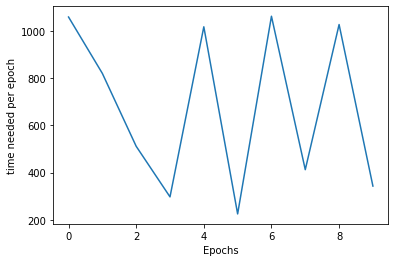

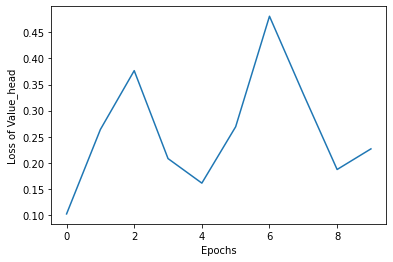

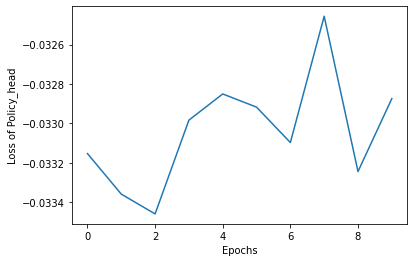

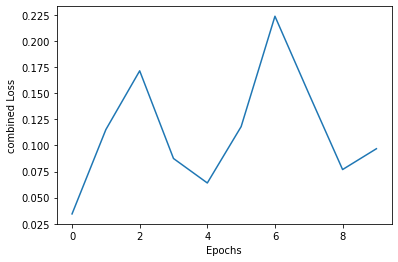

In [99]:
test = Testclass()
test.trainagent(n_epochs = 10, save_suffix="Final_trained", load_suffix = "no_message_training9", num_steps = 10)

# Plot Figure displaying the needed time each epoch
plt.figure()
plt.plot(test.times_per_epoch)
plt.xlabel("Epochs")
plt.ylabel("time needed per epoch")
plt.show()

# # Plot Figure displaying the loss each epoch
plt.figure()
plt.plot(test.losses_val_per_epoch)
plt.xlabel("Epochs")
plt.ylabel("Loss of Value_head")
plt.show()

plt.figure()
plt.plot(test.losses_pol_per_epoch)
plt.xlabel("Epochs")
plt.ylabel("Loss of Policy_head")
plt.show()

plt.figure()
plt.plot(test.losses_per_epoch)
plt.xlabel("Epochs")
plt.ylabel("combined Loss")
plt.show()

In [ ]:
bm = Boardmanager()
bm.compare_agents(load_team1_from = "no_message_training1", load_team2_from = "no_message_training9", num_steps= 10)